In [1]:
#importing necessary libraries
import numpy as np 
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import scipy.optimize as opt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from math import sqrt
from scipy.optimize import curve_fit

#defining normalization function
def norm(array):
    """ Returns array normalised to [0,1] """
    min_val = np.min(array)
    max_val = np.max(array)
    scaled = (array - min_val) / (max_val - min_val)

    return scaled


def norm_df(df):
    """ 
    Returns all columns of the dataframe normalised to [0,1] with the 
    exception the first (containing the names)
    Calls function norm to do the normalisation of one column, but
    doing all in one function is also fine. 
    """
    # iterate over all columns
    for col in df.columns[1:]: # excluding the first column
        df[col] = norm(df[col])
        
    return df

In [2]:
#import the dataset
df = pd.read_csv('API_19_DS2_en_csv_v2_3470836.csv', header=2)
df.head()


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Urban population (% of total population),SP.URB.TOTL.IN.ZS,50.776,50.761000,50.746000,50.730000,50.715000,50.700000,...,42.957000,42.990000,43.041000,43.108000,43.192000,43.293000,43.411000,43.546000,43.697000,NaN
1,Aruba,ABW,Urban population,SP.URB.TOTL,27525.000,28139.000000,28537.000000,28763.000000,28922.000000,29080.000000,...,44059.000000,44351.000000,44666.000000,44978.000000,45293.000000,45614.000000,45949.000000,46294.000000,46654.000000,NaN
2,Aruba,ABW,Urban population growth (annual %),SP.URB.GROW,NaN,2.206183,1.404498,0.788835,0.551271,0.544810,...,0.543931,0.660561,0.707733,0.696090,0.697901,0.706219,0.731740,0.748028,0.774631,NaN
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.000,55434.000000,56234.000000,56699.000000,57029.000000,57357.000000,...,102565.000000,103165.000000,103776.000000,104339.000000,104865.000000,105361.000000,105846.000000,106310.000000,106766.000000,NaN
4,Aruba,ABW,Population growth (annual %),SP.POP.GROW,NaN,2.236462,1.432843,0.823502,0.580334,0.573498,...,0.503385,0.583290,0.590508,0.541048,0.502860,0.471874,0.459266,0.437415,0.428017,NaN


In [3]:

#cleaning the dataset
df.columns = df.columns.str.replace(' ', '_')
df.drop(df.columns[[1, 3, 65]], axis = 1, inplace = True)
pd.options.display.float_format = '{:.2f}'.format
df.head()


,Country_Name,Indicator_Name,1960,1961,1962,1963,1964,1965,1966,1967,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,Urban population (% of total population),50.78,50.76,50.75,50.73,50.72,50.70,50.69,50.67,...,42.94,42.96,42.99,43.04,43.11,43.19,43.29,43.41,43.55,43.70
1,Aruba,Urban population,27525.00,28139.00,28537.00,28763.00,28922.00,29080.00,29246.00,29411.00,...,43820.00,44059.00,44351.00,44666.00,44978.00,45293.00,45614.00,45949.00,46294.00,46654.00
2,Aruba,Urban population growth (annual %),nan,2.21,1.40,0.79,0.55,0.54,0.57,0.56,...,0.10,0.54,0.66,0.71,0.70,0.70,0.71,0.73,0.75,0.77
3,Aruba,"Population, total",54208.00,55434.00,56234.00,56699.00,57029.00,57357.00,57702.00,58044.00,...,102050.00,102565.00,103165.00,103776.00,104339.00,104865.00,105361.00,105846.00,106310.00,106766.00
4,Aruba,Population growth (annual %),nan,2.24,1.43,0.82,0.58,0.57,0.60,0.59,...,0.38,0.50,0.58,0.59,0.54,0.50,0.47,0.46,0.44,0.43


In [4]:
#Selecting the indicators and countries for the plotting
indicator = ['CO2 emissions (kt)','CO2 emissions from gaseous fuel consumption (kt)'
                  ,'CO2 emissions from liquid fuel consumption (kt)'
                  ,'CO2 emissions from solid fuel consumption (kt)']
country = ['China','India','United States','Indonesia','Brazil','Russia','Mexico','Japan','Iran','Canada',
                'Germany','France','United Kingdom','Italy','South Korea']

In [5]:
#Selecting the data from the particular country and indicator to form the cluster
df_co2int = df.loc[(df.Country_Name.isin(country)) & 
                      (df.Indicator_Name == 'CO2 intensity (kg per kg of oil equivalent energy use)')]
df_co2int.drop(df_co2int.columns[[1]], axis = 1, inplace = True)
df_co2int['average_co2intensity'] = df_co2int.mean(axis=1)
df_co2int = df_co2int.reset_index(drop=True)

D:\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [6]:
#Selecting the data from the particular country and indicator to form the cluster
df_co2 = df.loc[(df.Country_Name.isin(country)) & 
                      (df.Indicator_Name == 'CO2 emissions (kt)')]
df_co2.drop(df_co2.columns[[1]], axis = 1, inplace = True)
df_co2['average_co2'] = df_co2.mean(axis=1)
df_co2 = df_co2.reset_index(drop=True)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [7]:
#Selecting the data from the particular country and indicator to form the cluster
df_gaseous = df.loc[(df.Country_Name.isin(country)) & 
                      (df.Indicator_Name == 'CO2 emissions from gaseous fuel consumption (kt)')]
df_gaseous.drop(df_gaseous.columns[[1]], axis = 1, inplace = True)
df_gaseous['average_gaseous'] = df_gaseous.mean(axis=1)
df_gaseous = df_gaseous.reset_index(drop=True)


D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
#Selecting the data from the particular country and indicator to form the cluster
df_liquid = df.loc[(df.Country_Name.isin(country)) & 
                      (df.Indicator_Name == 'CO2 emissions from liquid fuel consumption (kt)')]
df_liquid.drop(df_liquid.columns[[1]], axis = 1, inplace = True)
df_liquid['average_liquid'] = df_liquid.mean(axis=1)
df_liquid = df_liquid.reset_index(drop=True)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
#Selecting the data from the particular country and indicator to form the cluster
df_solid = df.loc[(df.Country_Name.isin(country)) & 
                      (df.Indicator_Name == 'CO2 emissions from solid fuel consumption (kt)')]
df_solid.drop(df_solid.columns[[1]], axis = 1, inplace = True)
df_solid['average_solid'] = df_solid.mean(axis=1)
df_solid = df_solid.reset_index(drop=True)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
#Normalising the indicators
df_co2 = norm_df(df_co2)
df_gaseous = norm_df(df_gaseous)
df_liquid = norm_df(df_liquid)
df_solid = norm_df(df_solid)
df_co2int = norm_df(df_co2int)

#Clustering
df_cluster = pd.DataFrame(df_gaseous['Country_Name'])
df_cluster = df_cluster.join(df_co2['average_co2'])
df_cluster = df_cluster.join(df_co2int['average_co2intensity'])
df_cluster = df_cluster.join(df_gaseous['average_gaseous'])
df_cluster = df_cluster.join(df_liquid['average_liquid'])
df_cluster = df_cluster.join(df_solid['average_solid'])

df_cluster

,Country_Name,average_co2,average_co2intensity,average_gaseous,average_liquid,average_solid
0,Brazil,0.01,0.00,0.00,0.03,0.00
1,Canada,0.05,0.51,0.10,0.06,0.02
2,China,0.72,1.00,0.05,0.19,1.00
3,Germany,0.14,0.73,0.14,0.10,0.13
4,France,0.04,0.46,0.04,0.07,0.03
5,United Kingdom,0.08,0.97,0.09,0.05,0.09
6,Indonesia,0.00,0.17,0.02,0.00,0.01
7,India,0.13,0.30,0.01,0.05,0.19
8,Italy,0.03,0.90,0.06,0.06,0.01
9,Japan,0.17,0.84,0.08,0.22,0.11


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 0, 'Average co2 consumption')

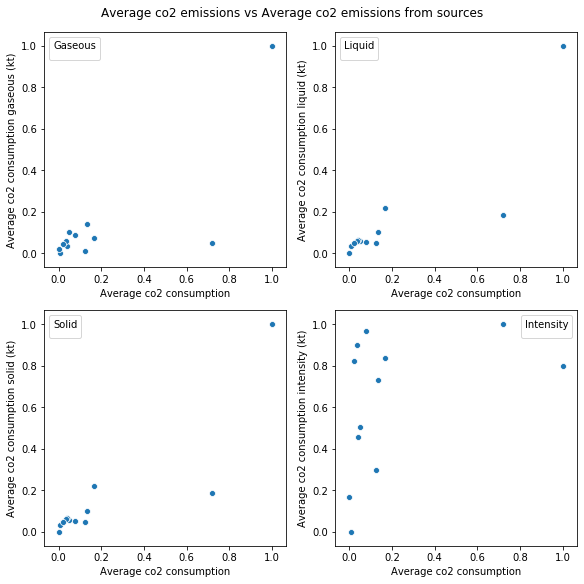

In [11]:
#Scatter Plotting
fig, axes = plt.subplots(2, 2, constrained_layout=True, figsize=(8,8))
fig.suptitle('Average co2 emissions vs Average co2 emissions from sources')

sns.scatterplot(ax=axes[0, 0], data=df_cluster, x='average_co2', y='average_gaseous')
axes[0,0].legend(title='Gaseous')
axes[0,0].set_ylabel("Average co2 consumption gaseous (kt)")
axes[0,0].set_xlabel("Average co2 consumption")

sns.scatterplot(ax=axes[0, 1], data=df_cluster, x='average_co2', y='average_liquid')
axes[0,1].legend(title='Liquid')
axes[0,1].set_ylabel("Average co2 consumption liquid (kt)")
axes[0,1].set_xlabel("Average co2 consumption")

sns.scatterplot(ax=axes[1, 0], data=df_cluster, x='average_co2', y='average_liquid')
axes[1,0].legend(title='Solid')
axes[1,0].set_ylabel("Average co2 consumption solid (kt)")
axes[1,0].set_xlabel("Average co2 consumption")

sns.scatterplot(ax=axes[1, 1], data=df_cluster, x='average_co2', y='average_co2intensity')
axes[1,1].legend(title='Intensity')
axes[1,1].set_ylabel("Average co2 consumption intensity (kt)")
axes[1,1].set_xlabel("Average co2 consumption")

No handles with labels found to put in legend.


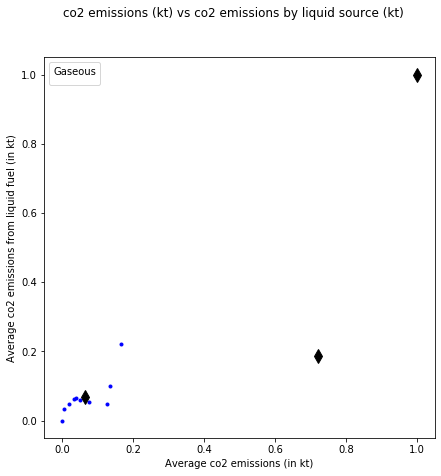

In [65]:
#Kmeans Clustering
kmeans = cluster.KMeans(n_clusters=3)
df_fit = df_cluster[["average_co2", "average_liquid"]].copy()
kmeans.fit(df_fit)     
labels = kmeans.labels_
cen = kmeans.cluster_centers_
plt.figure(figsize=(7.0,7.0))

col = ["blue", "red", "green"]
for l in range(3):  
    plt.plot(df_fit["average_co2"][labels==l], df_fit["average_liquid"][labels==l], "o", markersize=3, color=col[l])
    

for ic in range(3):
    xc, yc = cen[ic,:]
    plt.plot(xc, yc, "dk", markersize=10)
    

plt.suptitle('co2 emissions (kt) vs co2 emissions by liquid source (kt)')    
plt.legend(title='Gaseous')
plt.xlabel("Average co2 emissions (in kt)")
plt.ylabel("Average co2 emissions from liquid fuel (in kt)")
plt.show()